<a href="https://colab.research.google.com/github/Noy-Bo/Cancer-Cell-Segmentation/blob/master/Cancer_Cell_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Google Drive

mounting drive, setting root path to PanNuke dataset, setting device to cuda, checking out GPU


In [1]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import os
root_path = '/content/gdrive/MyDrive/PanNuke/' 
os.chdir(root_path)


In [3]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [4]:
!nvidia-smi

Fri Jul 23 06:23:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Dataset**
loading files, creating dataloaders, etc..



In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms import transforms
import torch
from torch.utils.data import Dataset
import numpy as np
import pickle


class PanNukeDataset(Dataset):
    def __init__(self, image_dir, masks_dir=None, cancer_types_dir=None, transform=None):
        #self.image_dir = image_dir
        #self.masks_dir = masks_dir
        #self.cancer_types_dir = cancer_types_dir
        self.transform = transform

        # Data is pickled into dictionaries ({'images': imgs, 'cancer_types': cancer_types, 'masks':masks}), let's open it up:
        with open(image_dir, mode='rb') as f:  # The with just manages closing of files and etc once finished.
            data_dict = pickle.load(f)  # load the original pickled dataset

        self.images = data_dict['images']
        self.cancer_types = data_dict['cancer_types']
        self.masks = data_dict['masks']

    def __len__(self):
        return self.images.shape[0]

    # returns images,masks   FOR NOW IT DOESN'T RETURN cancer_types!!!
    def __getitem__(self, index):
        image = self.images[index, ...].astype(dtype=np.float32)
        mask = self.masks[index, ...].astype(dtype=np.float32)
        mask[mask > 0] = 1.0

        # Set dimensions from 256x256xCH, to CHx256x256  - CHECK TO BE POSITIVE
        mask = np.moveaxis(mask, -1, 0)
        image = np.moveaxis(image, -1, 0)


        if self.transform is not None :
            augmentation = self.transform(image=image, mask=mask)
            image = augmentation["image"]
            mask = augmentation["mask"]

        return torch.from_numpy(image),torch.from_numpy(mask)

# Creating dataloaders
def load_dataset(batch_size, shuffle_flag, num_workers, data_dir, transforms=None):
  dataset = PanNukeDataset(data_dir)
  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_flag, num_workers=num_workers)
  return data_loader

# **Model**
basic UNet model configuration

In [6]:
from collections import OrderedDict

import torch
import torch.nn as nn


def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class Unet(nn.Module): # 0.244 on vallidation
    def __init__(self, scale=1):
        super().__init__()
        self.dblock1 = double_conv(3, 128*scale)
        self.dblock2 = double_conv(128*scale, 256*scale)
        self.dblock3 = double_conv(256*scale, 512*scale)
        self.dblock4 = double_conv(512*scale, 1024*scale)

        self.dropout = nn.Dropout2d()
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dblock5 = double_conv(512*scale + 1024*scale, 512*scale)
        self.dblock6 = double_conv(256*scale + 512*scale, 256*scale)
        self.dblock7 = double_conv(256*scale + 128*scale, 128*scale)
        self.relu = nn.ReLU()
        self.last_layer = nn.Conv2d(128*scale, 6, 1)
        #self.last_layer_rly = nn.Conv2d(512,6,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.dblock1(x)
        x = self.pool(conv1)

        conv2 = self.dblock2(x)
        x = self.pool(conv2)

        conv3 = self.dblock3(x)
        x = self.pool(conv3)
        x = self.dropout(x) # dropout
        
        conv4 = self.dblock4(x)
        conv4 = self.dropout(conv4) # dropout
        x = self.upsample(conv4)

        x = torch.cat([x, conv3], dim=1)

        

        x = self.dblock5(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dblock6(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dblock7(x)

        out = self.last_layer(x)
        #out = self.last_layer_rly(x)
        # out = self.sigmoid(x)
        return out


# class UNet(nn.Module):

#     def __init__(self, in_channels=3, out_channels=1, init_features=128):
#         super(UNet, self).__init__()

#         features = init_features
#         self.dropout = nn.Dropout2d()
#         self.encoder1 = UNet._block(in_channels, features, name="enc1")
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder2 = UNet._block(features, features * 2, name="enc2")
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
#         self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

#         self.upconv4 = nn.ConvTranspose2d(
#             features * 16, features * 8, kernel_size=2, stride=2
#         )
#         self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
#         self.upconv3 = nn.ConvTranspose2d(
#             features * 8, features * 4, kernel_size=2, stride=2
#         )
#         self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
#         self.upconv2 = nn.ConvTranspose2d(
#             features * 4, features * 2, kernel_size=2, stride=2
#         )
#         self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
#         self.upconv1 = nn.ConvTranspose2d(
#             features * 2, features, kernel_size=2, stride=2
#         )
#         self.decoder1 = UNet._block(features * 2, features, name="dec1")

#         self.conv_masks = nn.Conv2d(in_channels=features, out_channels=6, kernel_size=1)

#         # self.conv = nn.Conv2d(
#         #     in_channels=features, out_channels=out_channels, kernel_size=1
#         # )


#     def forward(self, x):
#         x = x.to(device)
#         enc1 = self.encoder1(x)
#         enc2 = self.encoder2(self.pool1(enc1))
#         enc3 = self.encoder3(self.pool2(enc2))
#         enc3 = self.dropout(enc3)
#         enc4 = self.encoder4(self.pool3(enc3))
#         enc4 = self.dropout(enc4)

#         bottleneck = self.bottleneck(self.pool4(enc4))
#         bottleneck = self.dropout(bottleneck)

#         dec4 = self.upconv4(bottleneck)
#         dec4 = torch.cat((dec4, enc4), dim=1)
#         dec4 = self.decoder4(dec4)
#         dec3 = self.upconv3(dec4)
#         dec3 = torch.cat((dec3, enc3), dim=1)
#         dec3 = self.decoder3(dec3)
#         dec2 = self.upconv2(dec3)
#         dec2 = torch.cat((dec2, enc2), dim=1)
#         dec2 = self.decoder2(dec2)
#         dec1 = self.upconv1(dec2)
#         dec1 = torch.cat((dec1, enc1), dim=1)
#         dec1 = self.decoder1(dec1)
#         #return torch.sigmoid(self.conv(dec1))
#         return torch.sigmoid(self.conv_masks(dec1))

#     @staticmethod
#     def _block(in_channels, features, name):
#         return nn.Sequential(
#             OrderedDict(
#                 [
#                     (
#                         name + "conv1",
#                         nn.Conv2d(
#                             in_channels=in_channels,
#                             out_channels=features,
#                             kernel_size=3,
#                             padding=1,
#                             bias=False,
#                         ),
#                     ),
#                     (name + "norm1", nn.BatchNorm2d(num_features=features)),
#                     (name + "relu1", nn.ReLU(inplace=True)),
#                     (
#                         name + "conv2",
#                         nn.Conv2d(
#                             in_channels=features,
#                             out_channels=features,
#                             kernel_size=3,
#                             padding=1,
#                             bias=False,
#                         ),
#                     ),
#                     (name + "norm2", nn.BatchNorm2d(num_features=features)),
#                     (name + "relu2", nn.ReLU(inplace=True)),
#                 ]
#             )
#         )

# **Data Utilities**

In [7]:

# calc normalization values of given data loader
def calc_normalization(data_loader):
    pop_mean = []
    pop_std0 = []
    pop_std1 = []
    for idx_batch, (images, masks) in enumerate(data_loader, 0):
     # shape (batch_size, 3, height, width)
     numpy_image = images.numpy()

     # shape (3,)
     batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
     batch_std0 = np.std(numpy_image, axis=(0, 2, 3))
     batch_std1 = np.std(numpy_image, axis=(0, 2, 3), ddof=1)

     pop_mean.append(batch_mean/255)
     pop_std0.append(batch_std0/255)
     pop_std1.append(batch_std1/255)

    # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
    pop_mean = np.array(pop_mean).mean(axis=0)
    print(pop_mean)
    pop_std0 = np.array(pop_std0).mean(axis=0)
    print(pop_std0)
    pop_std1 = np.array(pop_std1).mean(axis=0)
    print(pop_std1)


# VISUALIZING SAMPLES - designed for input that is the dataloader output, for raw input cancel moveaxis
def vis_sample(image, masks):
    fig, axs = plt.subplots(1,7)
    fig.set_size_inches(18.5, 3.2)
    fig.suptitle('Ground Truth', fontsize=18)
    #fig.tight_layout()
    axs[0].imshow(np.moveaxis(image.cpu().detach().numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
    masks = np.moveaxis(masks.cpu().detach().numpy().astype(np.uint8),0,-1)
    axs[1].imshow(masks[:,:,0], cmap="gray"); axs[1].set_title("Neoplastic cells")
    axs[2].imshow(masks[:,:,1], cmap="gray"); axs[2].set_title("Inflammatory")
    axs[3].imshow(masks[:,:,2], cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
    axs[4].imshow(masks[:,:,3], cmap="gray"); axs[4].set_title("Dead Cells")
    axs[5].imshow(masks[:,:,4], cmap="gray"); axs[5].set_title("Epithelial")
    axs[6].imshow(masks[:,:,5], cmap="gray"); axs[6].set_title("Background")
    plt.show()

# VISUALIZING PREDICTIONS - visualizing network output on a random sample.
def vis_predictions():
    image_gt_batch, masks_gt_batch = iter(validation_loader).next()
    image_gt_batch = image_gt_batch.to(device)
    masks_gt_batch = masks_gt_batch.to(device)
    pred_masks_batch = model(image_gt_batch)
      
    for i in range(image_gt_batch.shape[0]): # looping on batch_size
      print("\n\n")
      print("\t\t\t\t\t\t\t\t SAMPLE: {}".format(str(i)))
      image = image_gt_batch[i,...] # 3,256,256
      pred_masks = pred_masks_batch[i,...] # 6,256,256
      one_hot_masks = torch.nn.functional.one_hot(torch.argmax(pred_masks, dim=0))
      one_hot_masks = one_hot_masks.permute(2,0,1)
      one_hot_masks *= 250 # white color?
      fig, axs = plt.subplots(1,7)
      fig.set_size_inches(18.5, 3.3)
      fig.suptitle('Prediction', fontsize=18)
      #fig.tight_layout()
      axs[0].imshow(np.moveaxis(image.cpu().detach().numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
      axs[1].imshow(one_hot_masks[0,:,:].cpu().detach().numpy(), cmap="gray"); axs[1].set_title("Neoplastic cells")
      axs[2].imshow(one_hot_masks[1,:,:].cpu().detach().numpy(), cmap="gray"); axs[2].set_title("Inflammatory")
      axs[3].imshow(one_hot_masks[2,:,:].cpu().detach().numpy(), cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
      axs[4].imshow(one_hot_masks[3,:,:].cpu().detach().numpy(), cmap="gray"); axs[4].set_title("Dead Cells")
      axs[5].imshow(one_hot_masks[4,:,:].cpu().detach().numpy(), cmap="gray"); axs[5].set_title("Epithelial")
      axs[6].imshow(one_hot_masks[5,:,:].cpu().detach().numpy(), cmap="gray"); axs[6].set_title("Background")
      plt.show()

      vis_sample(image,masks_gt_batch[i,...]) # visualizing gt (ground truth)

# **Train Utilities**
loss functions configurations, train epoch function ..


In [8]:
import sys
import torch.nn as nn
import torch
import tqdm

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)


def CE(predict, target):
    cross_entropy = nn.CrossEntropyLoss()
    softmax = torch.nn.Softmax(dim=1)
    assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
    loss = 0
    target =  torch.argmax(target, dim=1)
    loss += cross_entropy(predict,target)
    return loss


def train_epoch(training_loader, model, optimizer, loss_function, overfit=False, images=None, masks=None,vis=False):

    losses = []
    model.train()
    with tqdm.tqdm(total=len(training_loader), file=sys.stdout) as pbar:
        for (images, masks) in training_loader:

            images = images.to(device)
            masks = masks.to(device)

            # calculate output
            y_hat = model(images)

            # calculate loss now:
            optimizer.zero_grad()
            loss = loss_function(y_hat, masks)
            loss.backward()

            # optimizing weights
            optimizer.step()

            # update loss bar
            losses.append(loss.detach())
            pbar.update();
            pbar.set_description(f'train loss={losses[-1]:.3f}')
        mean_loss = torch.mean(torch.FloatTensor(losses))
        pbar.set_description(f'train loss={mean_loss:.3f}')

        images = None
        masks = None
    return [mean_loss]

    
def eval_loss_epoch(training_loader, model, loss_function):

    losses = []
    model.eval()
    with tqdm.tqdm(total=len(training_loader), file=sys.stdout) as pbar:
        for idx_batch, (images, masks) in enumerate(training_loader, start=1):

            images = images.to(device)
            masks = masks.to(device)

            # calculate output
            y_hat = model(images)

            # calculate loss now:
            loss = loss_function(y_hat, masks)

            # optimizing weights

            # update loss bar
            losses.append(loss.detach())
            pbar.update();
            pbar.set_description(f'val loss={losses[-1]:.3f}')

            images = None
            masks = None
        mean_loss = torch.mean(torch.FloatTensor(losses))
        pbar.set_description(f'val loss={mean_loss:.3f}')

    return mean_loss

    
def train_on_1_batch(model, optimizer, loss_function, images, masks,vis=False):
    losses = []
    model.train()
    images = images.to(device)
    masks = masks.to(device)
    pred_masks_batch = model(images)
    for i in range(images.shape[0]): # looping on batch_size
      image = images[i,...] # 3,256,256
      pred_masks = pred_masks_batch[i,...]
      one_hot_masks = torch.nn.functional.one_hot(torch.argmax(pred_masks, dim=0))
      one_hot_masks = one_hot_masks.permute(2,0,1)
      one_hot_masks *= 250 # white color?

      if vis is True:
        print("\n\n")
        print("\t\t\t\t\t\t\t\t SAMPLE: {}".format(str(i)))
        fig, axs = plt.subplots(1,7)
        fig.set_size_inches(18.5, 3.3)
        fig.suptitle('Prediction', fontsize=18)
        #fig.tight_layout()
        axs[0].imshow(np.moveaxis(image.cpu().detach().numpy().astype(np.uint8),0,-1)); axs[0].set_title("Sample")
        axs[1].imshow(one_hot_masks[0,:,:].cpu().detach().numpy(), cmap="gray"); axs[1].set_title("Neoplastic cells")
        axs[2].imshow(one_hot_masks[1,:,:].cpu().detach().numpy(), cmap="gray"); axs[2].set_title("Inflammatory")
        axs[3].imshow(one_hot_masks[2,:,:].cpu().detach().numpy(), cmap="gray"); axs[3].set_title("Connective/Soft tissue cells")
        axs[4].imshow(one_hot_masks[3,:,:].cpu().detach().numpy(), cmap="gray"); axs[4].set_title("Dead Cells")
        axs[5].imshow(one_hot_masks[4,:,:].cpu().detach().numpy(), cmap="gray"); axs[5].set_title("Epithelial")
        axs[6].imshow(one_hot_masks[5,:,:].cpu().detach().numpy(), cmap="gray"); axs[6].set_title("Background")
        plt.show()

        vis_sample(image,masks[i,...]) # visualizing gt (ground truth)
    #calculate output
    y_hat = model(images)

    # calculate loss now:
    optimizer.zero_grad()
    loss = loss_function(y_hat, masks)
    loss.backward()

    # optimizing weights
    optimizer.step()

    # update loss bar
    losses.append(loss.detach())
    mean_loss = torch.mean(torch.FloatTensor(losses))
    return mean_loss


cuda


# **Creating Data Loaders**

In [9]:
train_dir = '/content/gdrive/MyDrive/Dataset/train_pickled_data'
val_dir = '/content/gdrive/MyDrive/Dataset/val_pickled_data'
test_dir = '/content/gdrive/MyDrive/Dataset/test_pickled_data'
# Grab loaders:
#load_dataset(2,None,None,None)
validation_loader = load_dataset(batch_size=6, shuffle_flag=True, num_workers=4, data_dir=val_dir)
test_loader = load_dataset(batch_size=6, shuffle_flag=True, num_workers=4, data_dir=test_dir)
training_loader = load_dataset(batch_size=6, shuffle_flag=True, num_workers=4, data_dir=train_dir)


# **Main (training)**


In [ ]:
from torchsummary import summary
import torch
import torch.nn as nn
# creating model
model = Unet(scale=2).to(device)
summary(model, (3,256,256))

# # visualization sample              # save every RAM we have!
# image, masks = iter(training_loader_1).next()
# vis_sample(image[0,...], masks[0,...])

# config training
epochs = 500
loss_function = CE
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999), eps =1e-08)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.9)


PATH = root_path + "model_UNet.pt"
min_val_loss = np.inf
# training
for i in range (1,epochs):
 print("=========================== EPOCH: {} ===========================".format(str(i)))
 print("TRAIN LOSS:")
 #train_epoch(training_loader=training_loader, model=model, optimizer=optimizer, loss_function=loss_function, overfit=True, images=image_batch, masks=masks_batch, vis=vis)
 train_epoch(training_loader=training_loader, model=model, optimizer=optimizer, loss_function=loss_function)
 print("VAL LOSS:")
 val_loss = eval_loss_epoch(training_loader=validation_loader, model=model, loss_function=loss_function)
 scheduler.step()
 if val_loss < min_val_loss:
   torch.save(model, PATH)
   min_val_loss = val_loss
 
 #vis_predictions()

# loading model
model = UNet().to(device)
model = torch.load(PATH)

# visualizing predictions
vis_predictions()

print("END")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 256, 256]           7,168
              ReLU-2        [-1, 256, 256, 256]               0
            Conv2d-3        [-1, 256, 256, 256]         590,080
              ReLU-4        [-1, 256, 256, 256]               0
         MaxPool2d-5        [-1, 256, 128, 128]               0
            Conv2d-6        [-1, 512, 128, 128]       1,180,160
              ReLU-7        [-1, 512, 128, 128]               0
            Conv2d-8        [-1, 512, 128, 128]       2,359,808
              ReLU-9        [-1, 512, 128, 128]               0
        MaxPool2d-10          [-1, 512, 64, 64]               0
           Conv2d-11         [-1, 1024, 64, 64]       4,719,616
             ReLU-12         [-1, 1024, 64, 64]               0
           Conv2d-13         [-1, 1024, 64, 64]       9,438,208
             ReLU-14         [-1, 1024,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss=0.573:  21%|██        | 218/1054 [06:13<23:51,  1.71s/it]

# **Visualizing Predictions vs Ground Truth**




								 SAMPLE: 0


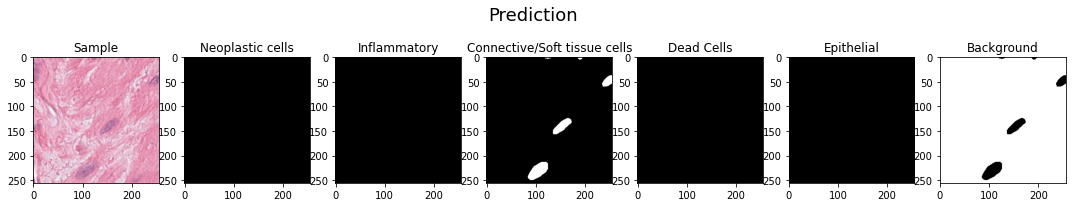

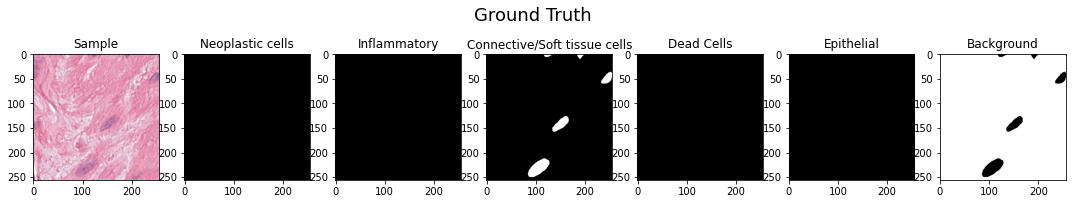




								 SAMPLE: 1


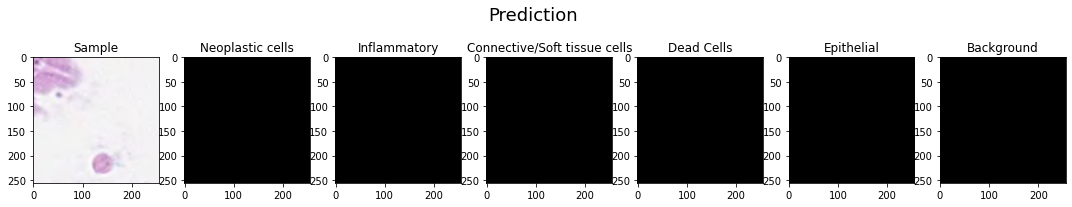

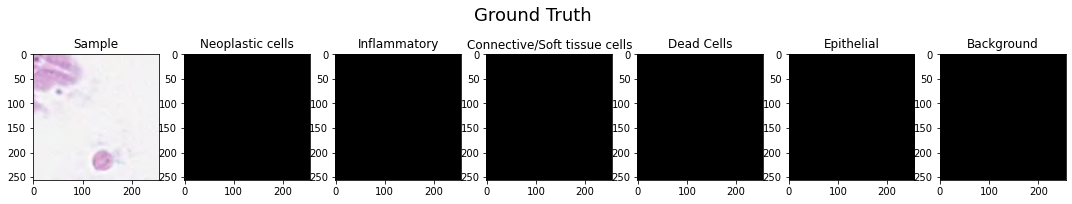




								 SAMPLE: 2


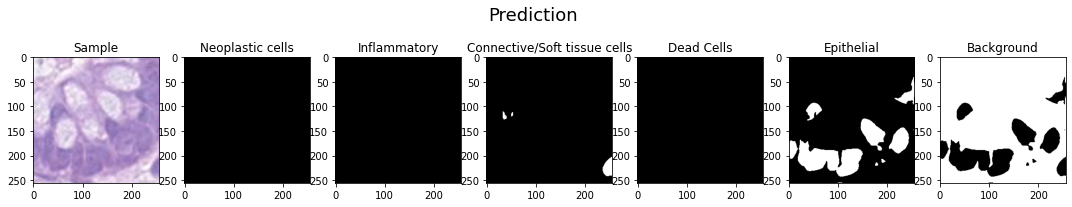

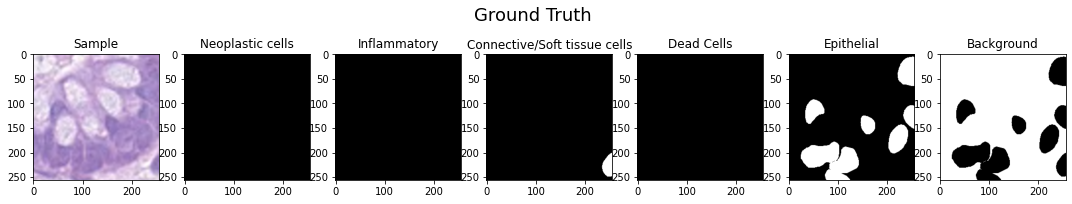




								 SAMPLE: 3


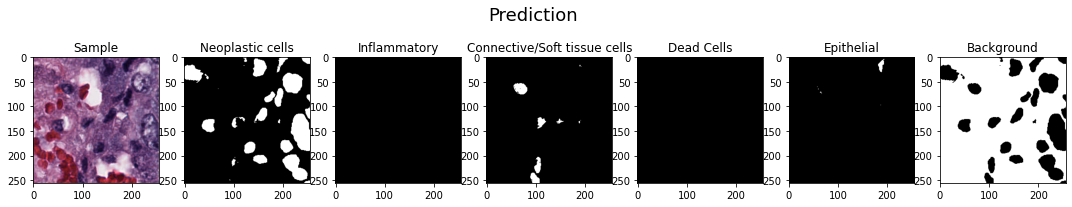

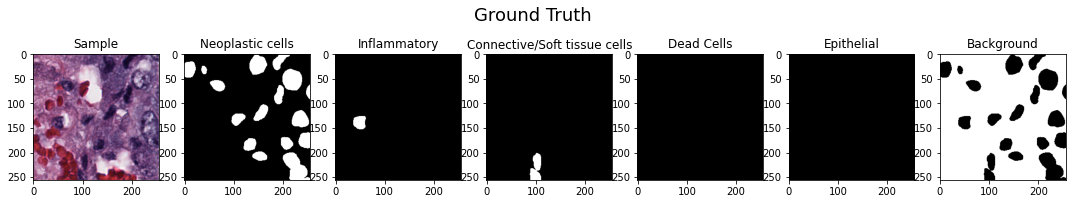




								 SAMPLE: 4


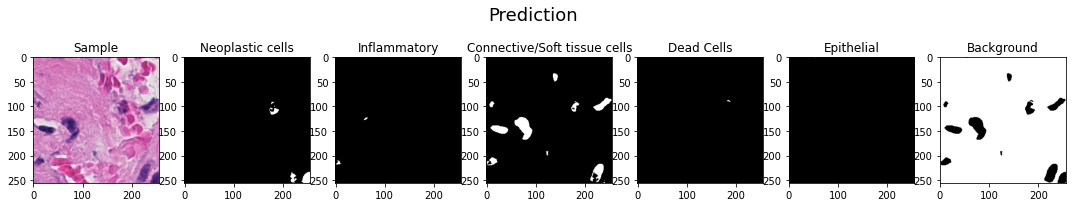

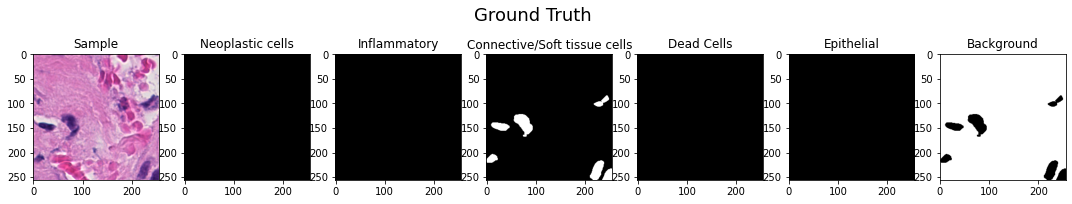




								 SAMPLE: 5


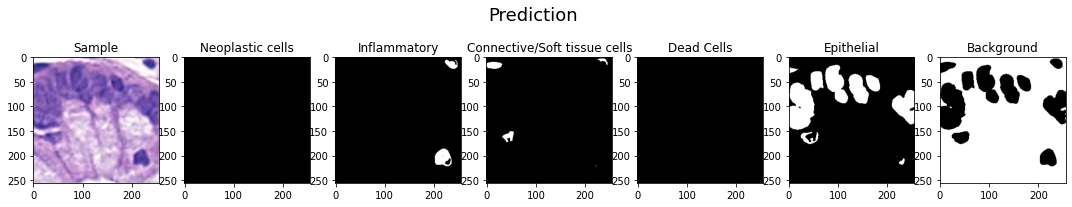

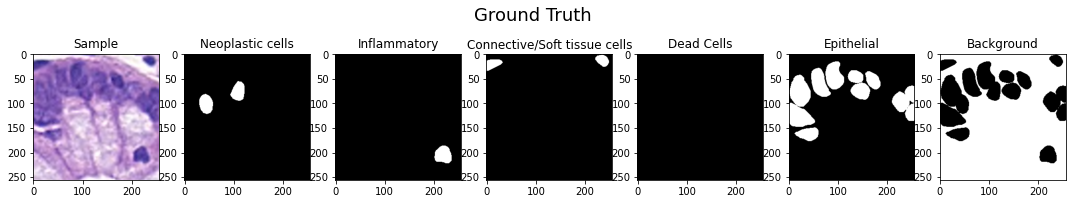




								 SAMPLE: 6


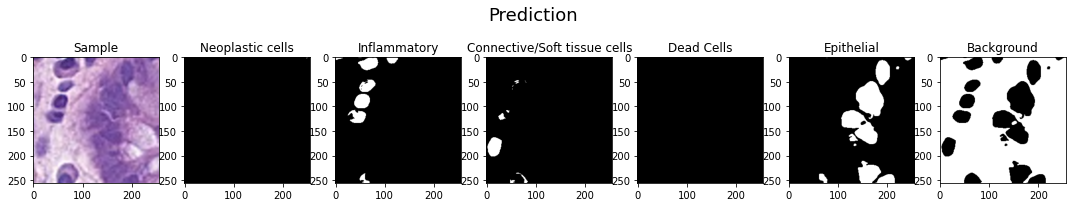

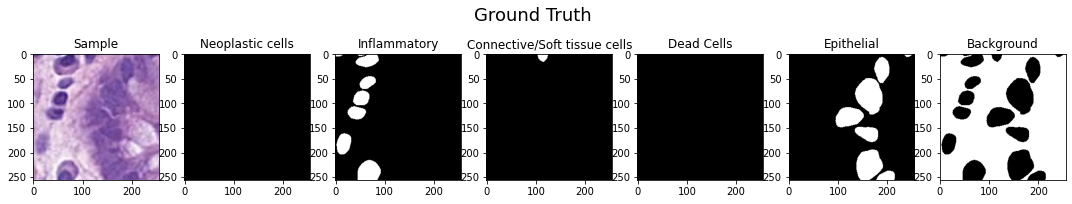




								 SAMPLE: 7


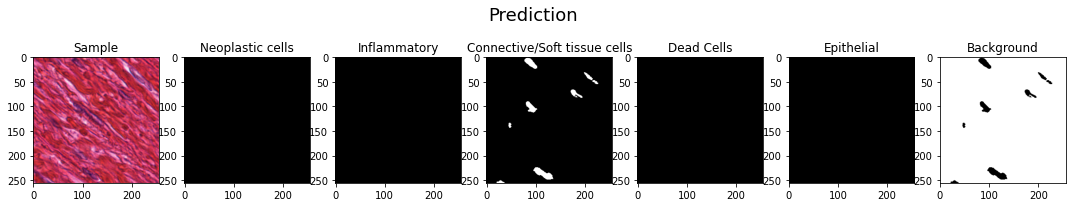

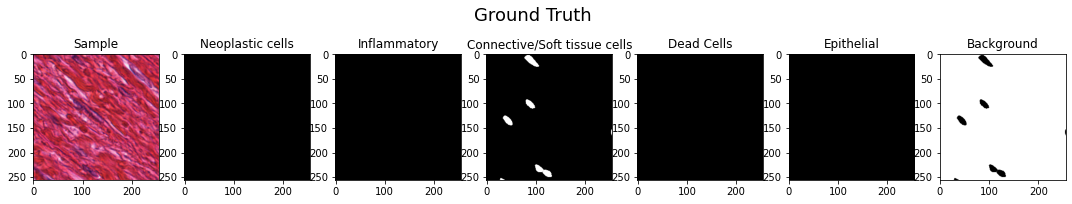




								 SAMPLE: 8


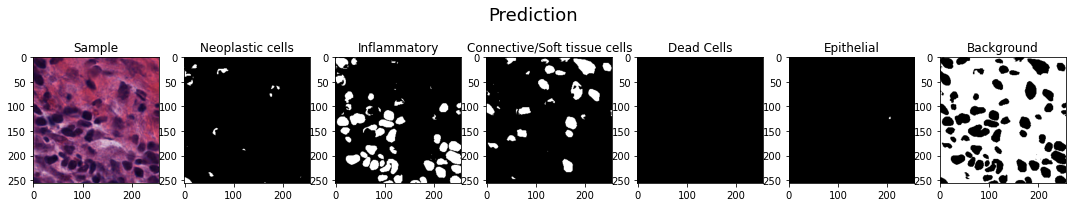

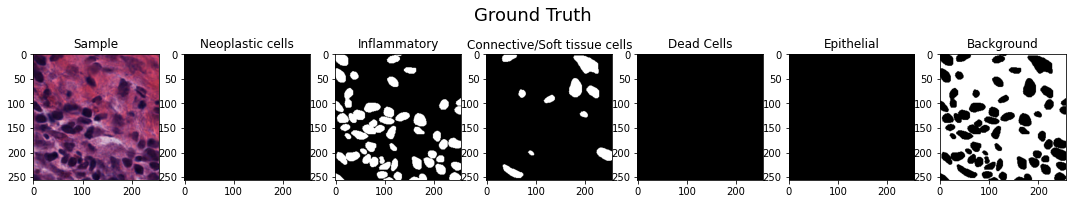




								 SAMPLE: 9


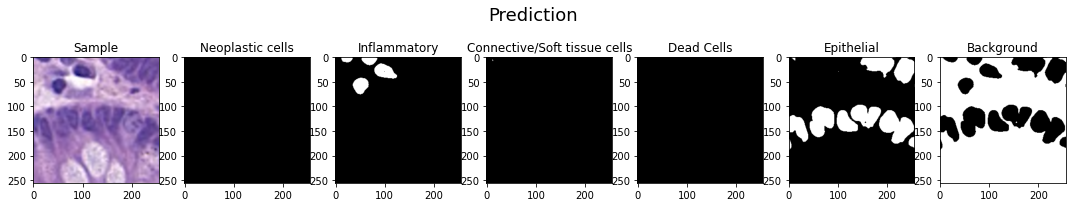

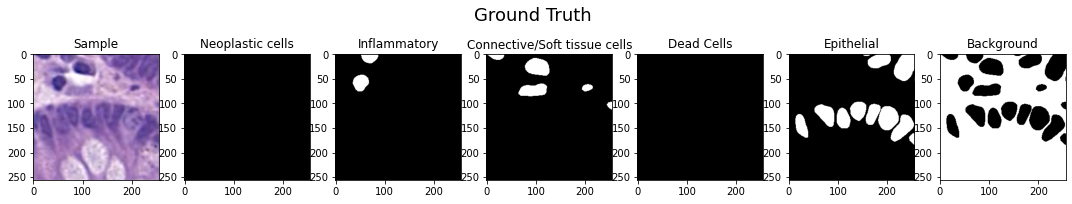




								 SAMPLE: 10


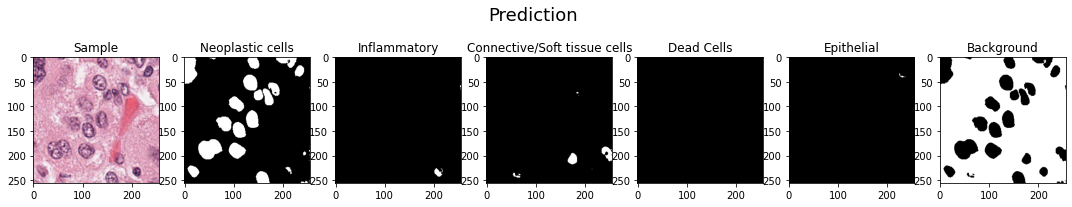

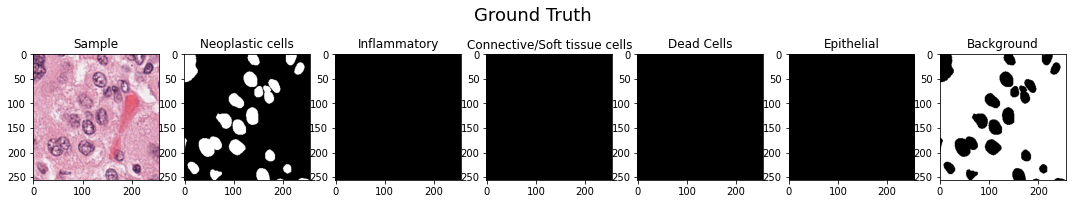




								 SAMPLE: 11


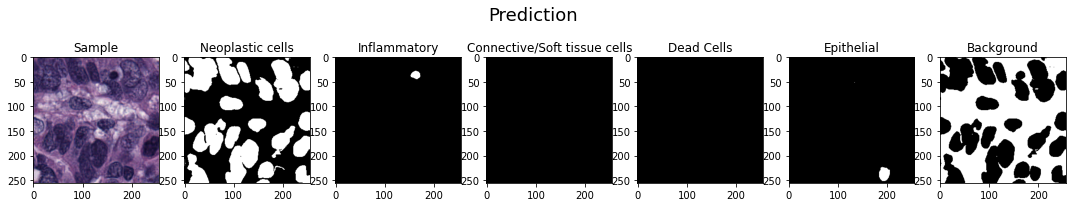

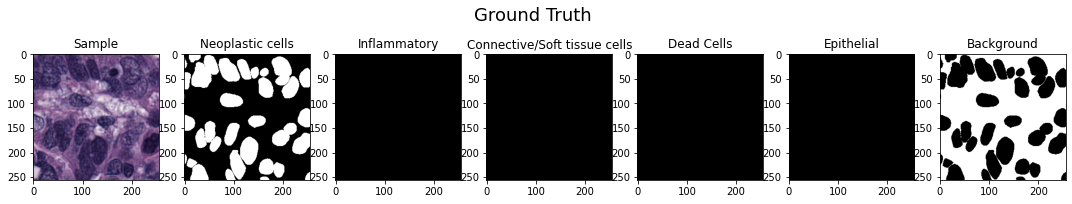

In [ ]:
#saving model
# PATH = root_path + "/model_UNet.pt"
# torch.save(model, PATH)

# model = UNet().to(device)
# PATH = root_path + "model_UNet.pt"
# model = torch.load(PATH)

vis_predictions()

In [ ]:
torch.cuda.empty_cache()
